In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use('gpu0') # some other variable would need to be set with the gpuarray backend
#import theano.gpuarray
#theano.gpuarray.use('cuda1')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)


In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import src.numpy_utility as pnu
import src.fwrf as fwrf
from src.fwrf import fpX
from src.plots import display_candidate_loss
from src.data_preparation import preprocess_gabor_feature_maps
from src.load_data import load_stimuli, load_voxels

theano floatX: float32
numpy floatX: <type 'numpy.float32'>


In [5]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime())

root_dir   = os.getcwd() + '/'
output_dir = root_dir+"output/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print "Time Stamp: %s" % timestamp

Time Stamp: Sep-19-2017_1214


In [6]:
dataset_dir = "/home/styvesg/Documents/PostDoc/Datasets/vim-1/"

# 1a) Load the image dataset (the images that were presented to the subject for which we have voxel data)

## Load vim-1 dataset

In [7]:
stimuli_lowrez, stimuli_hirez, trn_size = load_stimuli(dataset_dir, npx=227)

data_size = len(stimuli_hirez)
val_size = data_size - trn_size

trn_stim_data = stimuli_hirez[:trn_size]
val_stim_data = stimuli_hirez[trn_size:]

trn: 1750, val: 120
Data shape = (1870, 1, 227, 227)


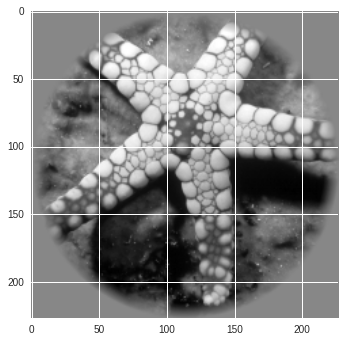

In [8]:
plt.imshow(trn_stim_data[5,0,:,:], cmap='gray')

# 1b) Load the corresponding voxel data

In [9]:
subject = 'S1'
roi_names = ['other', 'V1', 'V2', 'V3', 'V3a', 'V3b', 'V4', 'LO']

In [11]:
voxel_data, voxel_roi, voxel_idx = load_voxels(dataset_dir, subject) #, voxel_subset=range(3000, 4000))

nv = voxel_data.shape[1]
print "nv = %d" % nv

trn_voxel_data = voxel_data[:trn_size]
val_voxel_data = voxel_data[trn_size:]

22701 voxels contain valid values for all images
nv = 22701


# 0) Create the feature space and generate the feature maps for the dataset

In [12]:
model_name = 'gabor'
from gaborizer.src.gabor_feature_dictionaries import gabor_feature_maps

In [13]:
gabor_params = {
    'n_orientations': 4,
    'deg_per_stimulus': 20.,
    'lowest_sp_freq': 0.25, ##cyc/deg
    'highest_sp_freq': 6.0,
    'num_sp_freq': 12,
    'pix_per_cycle': 3.13, #2.13333333
    'complex_cell': True,
    'n_colors': 1, ##let's do grayscale first
    'diams_per_filter': 4.,
    'cycles_per_radius': 1.
}

print 'D = total number of features = %d' %(gabor_params['n_orientations'] * gabor_params['num_sp_freq'])

D = total number of features = 48


In [14]:
gfm = gabor_feature_maps(gabor_params['n_orientations'],
                         gabor_params['deg_per_stimulus'],
                         (gabor_params['lowest_sp_freq'], gabor_params['highest_sp_freq'], gabor_params['num_sp_freq']),
                         pix_per_cycle=gabor_params['pix_per_cycle'], complex_cell=gabor_params['complex_cell'],
                         diams_per_filter = gabor_params['diams_per_filter'],
                         cycles_per_radius = gabor_params['cycles_per_radius'])

In [15]:
print gfm.filter_stack.shape
gfm.gbr_table.head(17)

(48, 1, 25, 25)


,cycles per deg.,cycles_per_filter,filter size (deg.),pix per stimulus,pix_per_filter,radius of Gauss. envelope (deg),orientation
0,0.250000,8,32.000000,15.650000,25,4.000000,0.000000
1,0.333744,8,23.970452,20.892388,25,2.996307,0.000000
2,0.445541,8,17.955706,27.890856,25,2.244463,0.000000
3,0.594787,8,13.450200,37.233648,25,1.681275,0.000000
4,0.794027,8,10.075230,49.706060,25,1.259404,0.000000
5,1.060007,8,7.547120,66.356442,25,0.943390,0.000000
6,1.415085,8,5.653371,88.584316,25,0.706671,0.000000
7,1.889106,8,4.234808,118.258015,25,0.529351,0.000000
8,2.521912,8,3.172196,157.871718,25,0.396524,0.000000
9,3.366695,8,2.376218,210.755096,25,0.297027,0.000000


float64
(48, 1, 25, 25)


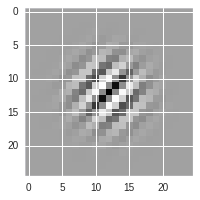

In [16]:
print np.real(gfm.filter_stack).dtype

#complex fs = np.stack([np.real(gfm.filter_stack), np.imag(gfm.filter_stack), np.zeros(shape=gfm.filter_stack.shape)]).transpose([1,2,3,4,0])
fs = np.real(gfm.filter_stack)
print fs.shape 
fig=plt.figure(figsize=(3,3))
plt.imshow(fs[15, 0, :, :], interpolation='None')

In [17]:
log_act_func = lambda x: np.log(1+np.sqrt(x))
fmaps, _fmaps, fmaps_sizes = preprocess_gabor_feature_maps(gfm.create_feature_maps(stimuli_hirez), log_act_func, dtype=fpX)

fmaps_res_count = len(fmaps_sizes)
fmaps_count = sum([fm[1] for fm in fmaps_sizes])
nf = fmaps_count

allocating memory for feature maps
constructing feature maps
feature 0 took 0.245311 s.
feature 1 took 0.271940 s.
feature 2 took 0.310585 s.
feature 3 took 0.391527 s.
feature 4 took 0.612312 s.
feature 5 took 1.018931 s.
feature 6 took 1.852650 s.
feature 7 took 3.364656 s.
feature 8 took 6.226860 s.
feature 9 took 11.488819 s.
feature 10 took 20.951593 s.
feature 11 took 38.356986 s.
feature 12 took 0.232260 s.
feature 13 took 0.252334 s.
feature 14 took 0.295602 s.
feature 15 took 0.393985 s.
feature 16 took 0.613219 s.
feature 17 took 1.022611 s.
feature 18 took 1.854825 s.
feature 19 took 3.354974 s.
feature 20 took 6.235528 s.
feature 21 took 11.512458 s.
feature 22 took 20.938717 s.
feature 23 took 38.349583 s.
feature 24 took 0.229638 s.
feature 25 took 0.249396 s.
feature 26 took 0.294238 s.
feature 27 took 0.393884 s.
feature 28 took 0.612233 s.
feature 29 took 1.020475 s.
feature 30 took 1.872468 s.
feature 31 took 3.353617 s.
feature 32 took 6.228349 s.
feature 33 took 11.

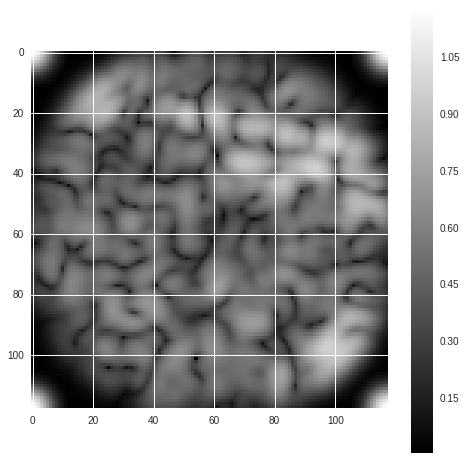

In [18]:
fig=plt.figure(figsize=(8,8))
plt.imshow(fmaps[7][-1,1,:,:], cmap='gray', interpolation='None')
plt.colorbar()

# 2) MODELS
## Define the search parameters

In [19]:
lx = ly = 20.
nx = ny = 26
smin, smax = 0.5, 8.
ns = 12

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
sharedModel_specs = [[(0., lx), (0., ly), (smin, smax)], [fwrf.linspace(nx), fwrf.linspace(ny), fwrf.logspace(ns)]]
# initial values of the fwrf model parameters
voxelParams = [np.full(shape=(nv, nf), fill_value=0.0, dtype=fpX)]#, np.full(shape=(nv), fill_value=0.0, dtype=fpX)]

print "G = %d\n" % (nx*ny*ns)
#print range:
print "range x"
print sharedModel_specs[1][0](*sharedModel_specs[0][0])
print "range y"
print sharedModel_specs[1][1](*sharedModel_specs[0][1])
print "range s"
print sharedModel_specs[1][2](*sharedModel_specs[0][2])

G = 8112

range x
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range y
[-9.61538506 -8.84615421 -8.07692337 -7.30769253 -6.53846169 -5.76923084
 -5.         -4.23076916 -3.46153855 -2.69230771 -1.92307687 -1.15384614
 -0.38461539  0.38461539  1.15384614  1.92307687  2.69230771  3.46153855
  4.23076916  5.          5.76923084  6.53846169  7.30769253  8.07692337
  8.84615421  9.61538506]
range s
[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


## Example of a f.p.f. as it appears at the different feature map resolutions

[ 0.5         0.64333242  0.82775331  1.06504107  1.37035096  1.76318252
  2.26862502  2.91896009  3.75572371  4.83235788  6.21762514  8.        ]


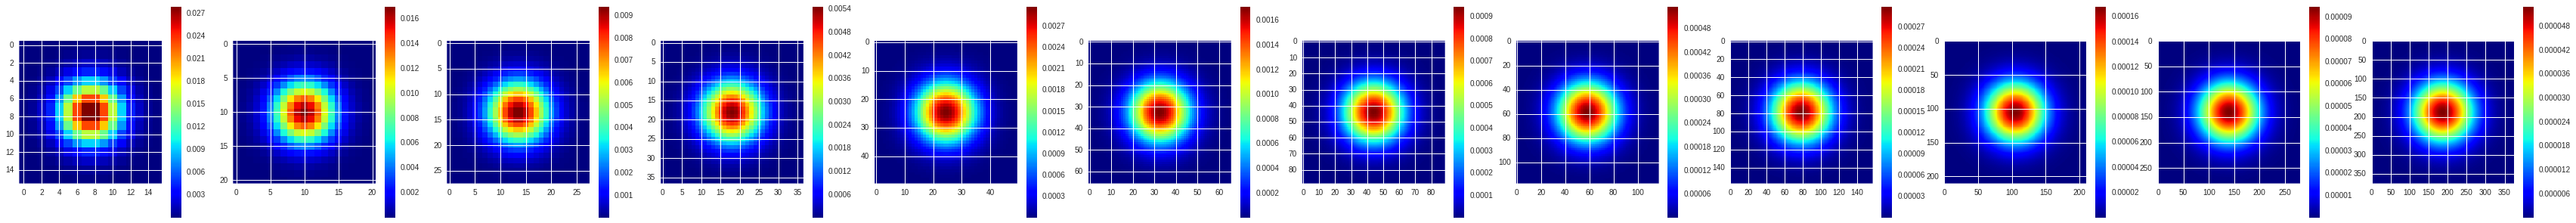

In [20]:
sigmas = sharedModel_specs[1][2](*sharedModel_specs[0][2])
print sigmas

ith_rf_size = 7
n = len(fmaps_sizes)
plt.figure(figsize=(5*n,5))
for i,r in enumerate(fmaps_sizes):
    _,_,z = pnu.make_gaussian_mass(0., 0., sigmas[ith_rf_size], r[2], size=20.)
    plt.subplot(1,n,i+1)
    plt.imshow(z, interpolation='None', cmap='jet')
    plt.colorbar()

---
# This is where the fwRF model is trained
## 2a) Precompute and save the modelspace tensor

In [21]:
mst_data, mst_avg, mst_std = fwrf.model_space_tensor(fmaps, sharedModel_specs, nonlinearity=None, \
                zscore=True, trn_size=trn_size, epsilon=1e-6, batches=(500, nx*ny), view_angle=lx, verbose=True, dry_run=False)
print mst_data.shape

CREATING SYMBOLS

> feature map candidates 0 with shape (1, 676, 16, 16)
> feature map candidates 1 with shape (1, 676, 21, 21)
> feature map candidates 2 with shape (1, 676, 28, 28)
> feature map candidates 3 with shape (1, 676, 37, 37)
> feature map candidates 4 with shape (1, 676, 50, 50)
> feature map candidates 5 with shape (1, 676, 66, 66)
> feature map candidates 6 with shape (1, 676, 89, 89)
> feature map candidates 7 with shape (1, 676, 118, 118)
> feature map candidates 8 with shape (1, 676, 158, 158)
> feature map candidates 9 with shape (1, 676, 211, 211)
> feature map candidates 10 with shape (1, 676, 281, 281)
> feature map candidates 11 with shape (1, 676, 376, 376)
  total number of feature maps = 48, in 12 layers
  feature map candidate using approx 828.7 Mb of memory (VRAM and RAM)
>> Storing the full modelspace tensor will require approx 2.713Gb of RAM!
>> Will be divided in chunks of 0.226Gb of VRAM!

COMPILING...
4.40 seconds to compile theano functions

Precomputi

100%|██████████| 12/12 [02:31<00:00, 12.62s/it]

8112 mst candidate responses took 151.699s @ 53.474 models/s
Z-scoring modelspace tensor...
Using self z-scoring values.



12it [00:10,  1.17it/s]

(1870, 48, 1, 8112)


In [22]:
print np.amin(mst_data), np.amax(mst_data)
# split the model space tensor into trn and val set.
trn_mst_data = mst_data[:trn_size]
val_mst_data = mst_data[trn_size:]

-22.4696 13.9495


## 2b) Learn the model parameters

In [24]:
val_scores, best_scores, best_epochs, best_candidates, best_w_params = fwrf.learn_params(
        trn_mst_data, trn_voxel_data, voxelParams, batches=(200, 1000, 2*nx*ny), \
        holdout_size=350, lr=1e-3, l2=0.0, num_epochs=40, output_val_scores=-1, output_val_every=1, verbose=True, dry_run=False)

Grad. Desc. planned in 7 batch with batch size 200 and residual 0
22 voxel batches of size 1000 with residual 701
6 candidate batches of size 1352 with residual 0
for 184150512 voxelmodel fits.
CREATING SYMBOLS

Layer	: <lasagne.layers.input.InputLayer object at 0x7f1c0f984d90>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 48, 1352)


Layer	: <src.fwrf.svFWRFLayer object at 0x7f1c0dc63110>
Name	: None
Type	: <class 'src.fwrf.svFWRFLayer'>
Shape	: (None, 1000, 1352)
Params
        |-- W         : (48, 1000, 1352)


COMPILING...
0.49 seconds to compile theano functions

Voxel-Candidates model optimization...

0it [00:00, ?it/s]



  Voxel 0:1000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss

1it [05:54, 354.88s/it]


  Voxel 1000:2000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005659
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <loss>: 0.005663
    validation <loss>: 0.005663
    validation <loss>: 0.005664
    validation <loss>: 0.005664
    validation <loss>: 0.005664
    validation <loss>: 0.005665
    validation <loss>: 0.005665
    validation <loss>: 0.005666
    validation <loss>: 0.005666
    validation <lo

2it [11:50, 355.01s/it]


  Voxel 2000:3000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005710
    validation <loss>: 0.005711
    validation <loss>: 0.005712
    validation <loss>: 0.005712
    validation <loss>: 0.005713
    validation <loss>: 0.005713
    validation <loss>: 0.005714
    validation <loss>: 0.005714
    validation <loss>: 0.005715
    validation <loss>: 0.005715
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005716
    validation <loss>: 0.005717
    validation <loss>: 0.005717
    validation <loss>: 0.005717
    validation <loss>: 0.005718
    validation <loss>: 0.005718
    validation <loss>: 0.005719
    validation <loss>: 0.005719
    validation <loss>: 0.005720
    validation <loss>: 0.005720
    validation <loss>: 0.005720
    validation <loss>: 0.005721
    validation <loss>: 0.005721
    validation <loss>: 0.005722
    validation <loss>: 0.005722
    validation <loss>: 0.005722
    validation <loss>: 0.005723
    validation <lo

3it [17:45, 355.10s/it]


  Voxel 3000:4000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005662
    validation <loss>: 0.005660
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005662
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <loss>: 0.005663
    validation <loss>: 0.005663
    validation <loss>: 0.005664
    validation <lo

4it [23:40, 355.19s/it]


  Voxel 4000:5000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005738
    validation <loss>: 0.005739
    validation <loss>: 0.005740
    validation <loss>: 0.005741
    validation <loss>: 0.005742
    validation <loss>: 0.005742
    validation <loss>: 0.005743
    validation <loss>: 0.005743
    validation <loss>: 0.005744
    validation <loss>: 0.005744
    validation <loss>: 0.005745
    validation <loss>: 0.005745
    validation <loss>: 0.005745
    validation <loss>: 0.005746
    validation <loss>: 0.005746
    validation <loss>: 0.005747
    validation <loss>: 0.005747
    validation <loss>: 0.005748
    validation <loss>: 0.005748
    validation <loss>: 0.005749
    validation <loss>: 0.005749
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005750
    validation <loss>: 0.005751
    validation <loss>: 0.005751
    validation <loss>: 0.005752
    validation <loss>: 0.005752
    validation <loss>: 0.005753
    validation <lo

5it [29:37, 355.62s/it]


  Voxel 5000:6000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005625
    validation <loss>: 0.005623
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005625
    validation <loss>: 0.005625
    validation <loss>: 0.005625
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <lo

6it [35:32, 355.48s/it]


  Voxel 6000:7000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005718
    validation <loss>: 0.005719
    validation <loss>: 0.005720
    validation <loss>: 0.005720
    validation <loss>: 0.005721
    validation <loss>: 0.005722
    validation <loss>: 0.005722
    validation <loss>: 0.005723
    validation <loss>: 0.005723
    validation <loss>: 0.005723
    validation <loss>: 0.005724
    validation <loss>: 0.005724
    validation <loss>: 0.005725
    validation <loss>: 0.005725
    validation <loss>: 0.005725
    validation <loss>: 0.005726
    validation <loss>: 0.005726
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005727
    validation <loss>: 0.005728
    validation <loss>: 0.005728
    validation <loss>: 0.005729
    validation <loss>: 0.005729
    validation <loss>: 0.005730
    validation <loss>: 0.005730
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <loss>: 0.005731
    validation <lo

7it [41:27, 355.32s/it]


  Voxel 7000:8000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005612
    validation <loss>: 0.005608
    validation <loss>: 0.005607
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005606
    validation <loss>: 0.005607
    validation <loss>: 0.005607
    validation <loss>: 0.005607
    validation <loss>: 0.005607
    validation <loss>: 0.005607
    validation <loss>: 0.005608
    validation <loss>: 0.005608
    validation <loss>: 0.005608
    validation <loss>: 0.005609
    validation <loss>: 0.005609
    validation <loss>: 0.005609
    validation <loss>: 0.005610
    validation <loss>: 0.005610
    validation <loss>: 0.005610
    validation <loss>: 0.005611
    validation <lo

8it [47:22, 355.17s/it]


  Voxel 8000:9000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005688
    validation <loss>: 0.005689
    validation <loss>: 0.005689
    validation <loss>: 0.005690
    validation <loss>: 0.005690
    validation <loss>: 0.005691
    validation <loss>: 0.005691
    validation <loss>: 0.005692
    validation <loss>: 0.005692
    validation <loss>: 0.005692
    validation <loss>: 0.005693
    validation <loss>: 0.005693
    validation <loss>: 0.005694
    validation <loss>: 0.005694
    validation <loss>: 0.005694
    validation <loss>: 0.005695
    validation <loss>: 0.005695
    validation <loss>: 0.005696
    validation <loss>: 0.005696
    validation <loss>: 0.005696
    validation <loss>: 0.005697
    validation <loss>: 0.005697
    validation <loss>: 0.005698
    validation <loss>: 0.005698
    validation <loss>: 0.005699
    validation <loss>: 0.005699
    validation <loss>: 0.005699
    validation <loss>: 0.005700
    validation <loss>: 0.005700
    validation <lo

9it [53:17, 355.04s/it]


  Voxel 9000:10000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005656
    validation <loss>: 0.005653
    validation <loss>: 0.005652
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005658
    validation <l

10it [59:12, 355.13s/it]


  Voxel 10000:11000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005652
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005662
    validation <loss>: 0.005662
    validation <

11it [1:05:07, 355.03s/it]


  Voxel 11000:12000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005654
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <

12it [1:11:02, 355.03s/it]


  Voxel 12000:13000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005670
    validation <loss>: 0.005668
    validation <loss>: 0.005667
    validation <loss>: 0.005667
    validation <loss>: 0.005667
    validation <loss>: 0.005668
    validation <loss>: 0.005668
    validation <loss>: 0.005668
    validation <loss>: 0.005669
    validation <loss>: 0.005669
    validation <loss>: 0.005669
    validation <loss>: 0.005670
    validation <loss>: 0.005670
    validation <loss>: 0.005670
    validation <loss>: 0.005671
    validation <loss>: 0.005671
    validation <loss>: 0.005671
    validation <loss>: 0.005672
    validation <loss>: 0.005672
    validation <loss>: 0.005672
    validation <loss>: 0.005673
    validation <loss>: 0.005673
    validation <loss>: 0.005674
    validation <loss>: 0.005674
    validation <loss>: 0.005674
    validation <loss>: 0.005675
    validation <loss>: 0.005675
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <

13it [1:16:58, 355.24s/it]


  Voxel 13000:14000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005676
    validation <loss>: 0.005677
    validation <loss>: 0.005677
    validation <loss>: 0.005677
    validation <loss>: 0.005677
    validation <loss>: 0.005677
    validation <loss>: 0.005677
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>: 0.005678
    validation <loss>: 0.005679
    validation <loss>: 0.005679
    validation <loss>: 0.005679
    validation <loss>: 0.005680
    validation <loss>: 0.005680
    validation <loss>: 0.005680
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005681
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005682
    validation <loss>: 0.005683
    validation <

14it [1:22:52, 355.03s/it]


  Voxel 14000:15000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005633
    validation <loss>: 0.005628
    validation <loss>: 0.005626
    validation <loss>: 0.005625
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005625
    validation <loss>: 0.005625
    validation <loss>: 0.005625
    validation <loss>: 0.005625
    validation <loss>: 0.005625
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005629
    validation <

15it [1:28:46, 354.74s/it]


  Voxel 15000:16000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005644
    validation <loss>: 0.005645
    validation <loss>: 0.005645
    validation <loss>: 0.005646
    validation <loss>: 0.005646
    validation <loss>: 0.005646
    validation <loss>: 0.005647
    validation <loss>: 0.005647
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005649
    validation <loss>: 0.005649
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005654
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <

16it [1:34:41, 354.73s/it]


  Voxel 16000:17000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005639
    validation <loss>: 0.005635
    validation <loss>: 0.005633
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005636
    validation <

17it [1:40:37, 355.03s/it]


  Voxel 17000:18000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005635
    validation <loss>: 0.005632
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005636
    validation <loss>: 0.005636
    validation <

18it [1:46:32, 355.02s/it]


  Voxel 18000:19000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005611
    validation <loss>: 0.005610
    validation <loss>: 0.005609
    validation <loss>: 0.005610
    validation <loss>: 0.005610
    validation <loss>: 0.005610
    validation <loss>: 0.005611
    validation <loss>: 0.005611
    validation <loss>: 0.005611
    validation <loss>: 0.005611
    validation <loss>: 0.005612
    validation <loss>: 0.005612
    validation <loss>: 0.005612
    validation <loss>: 0.005612
    validation <loss>: 0.005613
    validation <loss>: 0.005613
    validation <loss>: 0.005613
    validation <loss>: 0.005613
    validation <loss>: 0.005614
    validation <loss>: 0.005614
    validation <loss>: 0.005614
    validation <loss>: 0.005615
    validation <loss>: 0.005615
    validation <loss>: 0.005615
    validation <loss>: 0.005616
    validation <loss>: 0.005616
    validation <loss>: 0.005617
    validation <loss>: 0.005617
    validation <loss>: 0.005617
    validation <

19it [1:52:27, 354.98s/it]


  Voxel 19000:20000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005629
    validation <loss>: 0.005628
    validation <loss>: 0.005627
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005629
    validation <loss>: 0.005629
    validation <loss>: 0.005629
    validation <loss>: 0.005630
    validation <

20it [1:58:22, 355.22s/it]


  Voxel 20000:21000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005604
    validation <loss>: 0.005600
    validation <loss>: 0.005599
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005597
    validation <loss>: 0.005597
    validation <loss>: 0.005597
    validation <loss>: 0.005597
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005599
    validation <loss>: 0.005599
    validation <loss>: 0.005599
    validation <loss>: 0.005599
    validation <loss>: 0.005599
    validation <loss>: 0.005600
    validation <loss>: 0.005600
    validation <loss>: 0.005600
    validation <loss>: 0.005600
    validation <loss>: 0.005601
    validation <loss>: 0.005601
    validation <

21it [2:04:17, 355.11s/it]


  Voxel 21000:22000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005626
    validation <loss>: 0.005622
    validation <loss>: 0.005620
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005620
    validation <loss>: 0.005620
    validation <loss>: 0.005620
    validation <loss>: 0.005620
    validation <loss>: 0.005621
    validation <loss>: 0.005621
    validation <loss>: 0.005621
    validation <loss>: 0.005621
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <

22it [2:10:13, 355.26s/it]


  Voxel 22000:22701 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.003946
    validation <loss>: 0.003945
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003944
    validation <loss>: 0.003945
    validation <loss>: 0.003945
    validation <loss>: 0.003945
    validation <loss>: 0.003945
    validation <loss>: 0.003945
    validation <loss>: 0.003945
    validation <loss>: 0.003946
    validation <loss>: 0.003946
    validation <loss>: 0.003946
    validation <loss>: 0.003946
    validation <loss>: 0.003946
    validation <loss>: 0.003947
    validation <loss>: 0.003947
    validation <loss>: 0.003947
    validation <loss>: 0.003947
    validation <loss>: 0.003948
    validation <loss>: 0.003948
    validation <loss>: 0.003948
    validation <

23it [2:16:11, 356.18s/it]


---------------------------------------------------------------------
40 Epoch for 184150512 voxelmodels took 8171.568s @ 22535.519 voxelmodels/s


## 2c) Convert modelspace tensor best candidates into real space and separate voxel models

In [25]:
best_rf_params, best_avg, best_std = fwrf.real_space_model(best_candidates, sharedModel_specs, mst_avg=mst_avg, mst_std=mst_std)

## 2d) Validate the best models and display the distribution of prediction accuracy

In [26]:
val_pred, val_cc = fwrf.get_prediction(val_mst_data, val_voxel_data, best_candidates, best_w_params, batches=(500, 2*ny*nx))

16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...


17it [00:01, 10.09it/s]

0.47 seconds to compile theano functions


max cc = 0.821870
sum(cc>0.2) = 2712


(-0.4, 0.9)

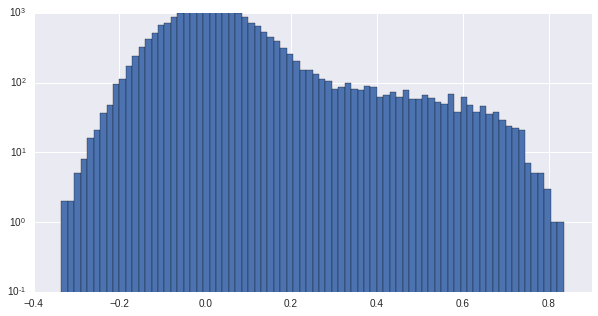

In [27]:
print "max cc = %f" % np.max(val_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_cc))
plt.figure(figsize=(10,5))
_=plt.hist(val_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

---
# Quick diagnostic of learning

[-4.23076916 -0.38461539  0.64333242]


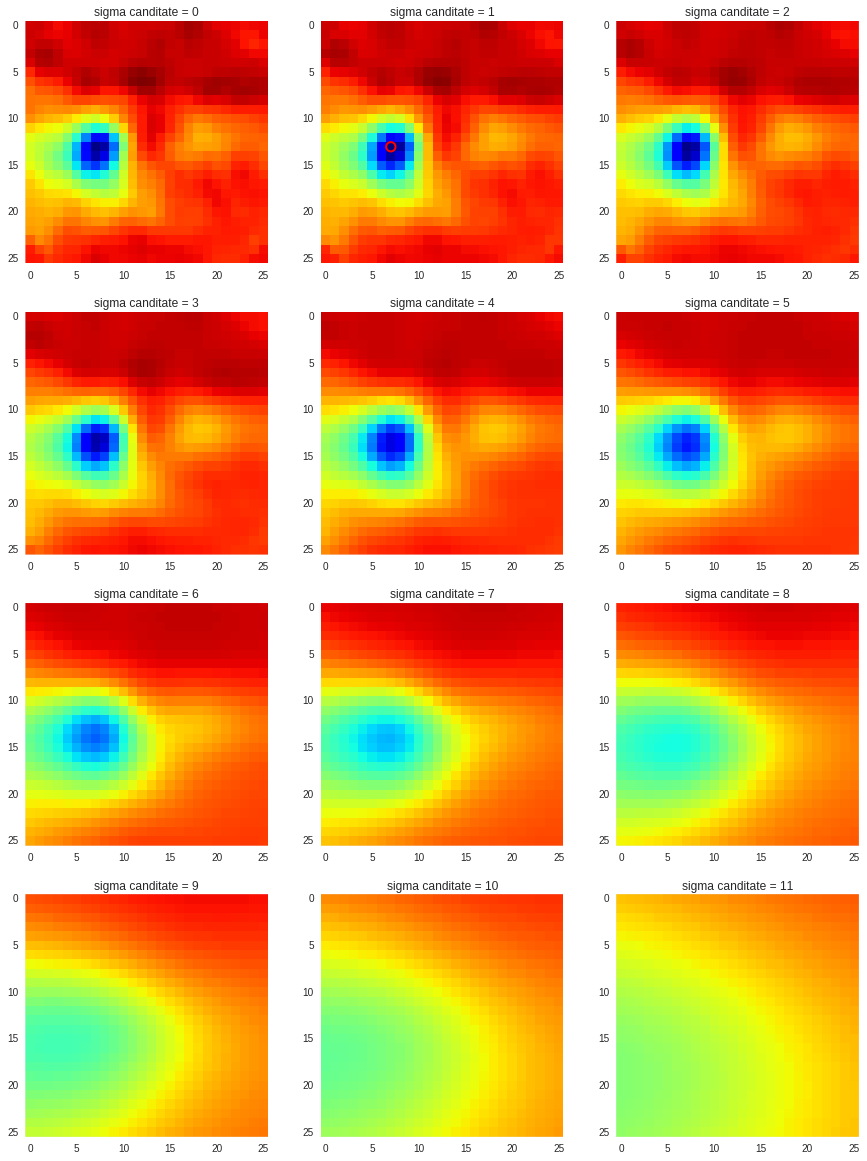

In [28]:
vidx = np.argmax(val_cc)
print best_rf_params[vidx,:]
fig1 = display_candidate_loss(val_scores[-1,vidx,:], nx, ny, ns)

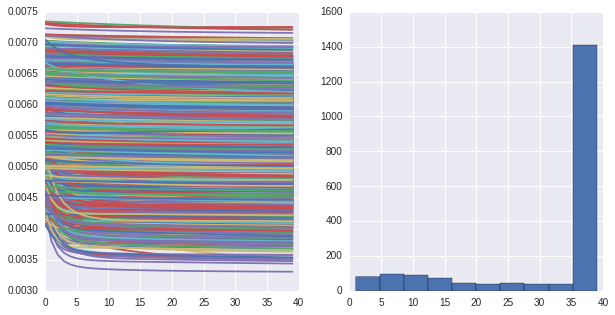

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for v in range(val_scores.shape[1]):
    plt.plot(val_scores[:,v,best_candidates[v]])
plt.subplot(1,2,2)    
_=plt.hist(best_epochs[val_cc>0.27])

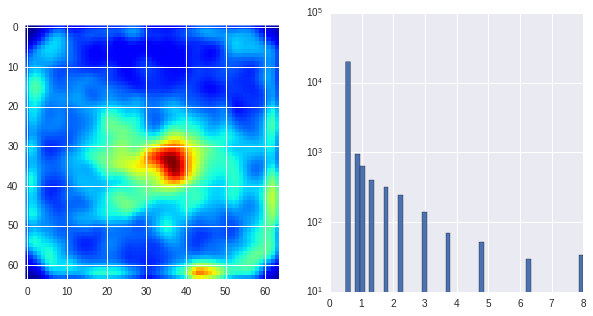

In [30]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
_,_,g_stack = pnu.make_gaussian_stack(best_rf_params[:,0], best_rf_params[:,1], best_rf_params[:,2], 64, size=20., dtype=fpX)
plt.imshow(np.sum(g_stack, axis=0), interpolation='None', cmap='jet')
plt.subplot(1,2,2)
_=plt.hist(best_rf_params[:,2], bins=50)
plt.yscale('log')

[[ 1.          0.82186995]
 [ 0.82186995  1.        ]]


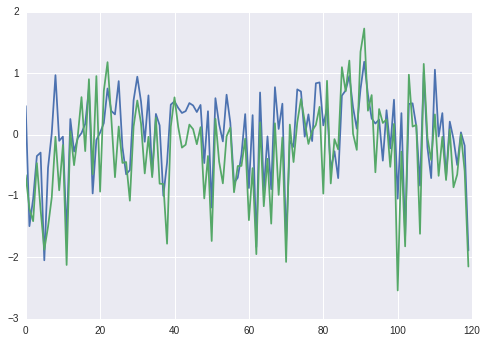

In [31]:
plt.plot(val_pred[:,vidx])
plt.plot(val_voxel_data[:,vidx])

print np.corrcoef(val_pred[:,vidx], val_voxel_data[:,vidx])

In [ ]:
***

In [32]:
ex_file_name = output_dir + "fwrf_%s_%s_%s_data.pkl" % (model_name, subject, timestamp)
ex_file = open(ex_file_name, 'wb')
ex_values = {'project': 'fwrf',
             'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'gabor_params': gabor_params,
             'voxel_idx': voxel_idx,
             'voxel_roi': voxel_roi,             
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes, 
             'scores': best_scores,
             'rf_params': best_rf_params,
             'w_params': best_w_params,
             'normavg': best_avg,
             'normstd': best_std, 
             'val_pred': val_pred,
             'val_cc': val_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

/home/styvesg/Documents/PostDoc/GitRepo/fwrf/output/fwrf_gabor_S1_Sep-19-2017_1214_data.pkl


In [41]:
#data_file = open(output_dir + "fwrf_model_S1_Feb-17-2017_1812.pkl", 'rb')
#data_value = pickle.load(data_file)
#data_file.close()

# Split accuracy by layer and roi

In [76]:
#find the start and end point of the feature map partitions
fmaps_count = len(fmaps_sizes)
partitions = [0,]
for r in fmaps_sizes:
    partitions += [partitions[-1]+r[1],]
print partitions

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]


In [91]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.zeros(p.shape, dtype=fpX) for p in best_w_params]  
    partition_params[0][:, partitions[l]:partitions[l+1]] = best_w_params[0][:, partitions[l]:partitions[l+1]]
    #partition_params[1][:] = best_w_params[1][:]

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.get_prediction(val_mst_data, val_voxel_data, best_candidates, partition_params, batches=(500, 2*ny*nx))

16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...


17it [00:01,  8.79it/s]

0.78 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:01,  8.55it/s]

0.48 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:01,  8.85it/s]

0.48 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.63it/s]

0.51 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.31it/s]

0.79 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.84it/s]

0.54 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:01,  8.81it/s]

0.49 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:01,  8.87it/s]

0.48 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.30it/s]

0.50 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.44it/s]

0.73 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.25it/s]

0.51 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  9.04it/s]

0.51 seconds to compile theano functions


In [92]:
# calculate covariances
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c = np.cov(val_pred[:,v], val_voxel_data[:,v])
    for l in range(fmaps_count):
        part_c = np.cov(partition_val_pred[l,:,v], val_voxel_data[:,v])
        partition_r[l,v] = part_c[0,1]/np.sqrt(full_c[0,0]*full_c[1,1])

In [93]:
part_file = open(output_dir + "fwrf_%s_%s_%s_part.pkl" % (model_name, subject, timestamp), 'wb')
part_values = {'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'val_pred': partition_val_pred,
             'val_cc': partition_val_cc,
             'val_ri': partition_r}
pickle.dump(part_values, part_file)
part_file.close()

In [95]:
nROI = int(np.max(voxel_roi))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxel_roi.flatten()==roi, val_cc>0.2)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask] /  val_cc[roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

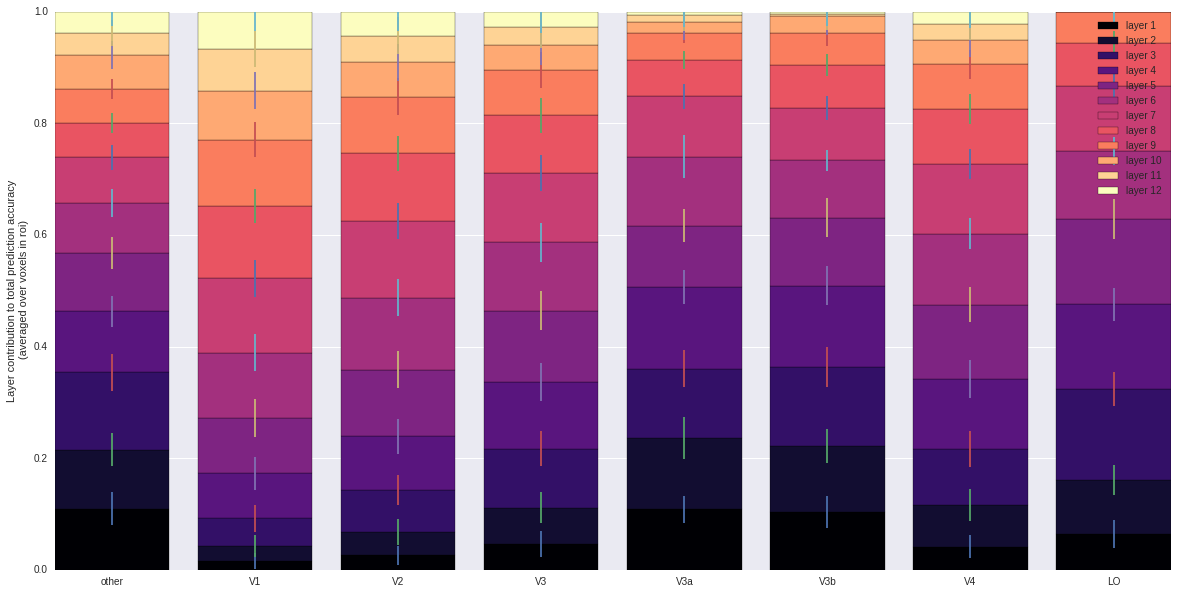

In [96]:
from matplotlib.pyplot import cm 
color=iter(cm.magma(np.linspace(0,1,nL)))

plt.figure(figsize=(20,10))
c=next(color)
plist = []
_ = plt.bar(np.arange(len(roi_names)), partition_R_avg[0,:], yerr=partition_R_std[0,:], color=c, align='center')
plist += [_,]
for l in range(1,nL):
    c=next(color)
    _= plt.bar(np.arange(len(roi_names)), partition_R_avg[l,:], bottom=np.sum(partition_R_avg[:l,:],axis=0), yerr=partition_R_std[l,:], color=c,\
        align='center', tick_label=roi_names)
    plist += [_,]
plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
plt.ylim([0,1])
plt.ylabel('Layer contribution to total prediction accuracy\n (averaged over voxels in roi)')

# Unique variance per frequency

In [106]:
partition_val_pred = np.ndarray(shape=(fmaps_count,)+val_pred.shape, dtype=fpX)
partition_val_cc   = np.ndarray(shape=(fmaps_count,)+val_cc.shape, dtype=fpX)

for l in range(fmaps_count):
    partition_params = [np.copy(w) for w in best_w_params]
    partition_params[0][:, partitions[l]:partitions[l+1]] = 0

    partition_val_pred[l,...], partition_val_cc[l,...] = fwrf.get_prediction(val_mst_data, val_voxel_data, best_candidates, partition_params, batches=(500, 2*ny*nx))

16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...


17it [00:02,  8.68it/s]

0.55 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  7.79it/s]

0.82 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.21it/s]

0.49 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.52it/s]

0.52 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.62it/s]

0.50 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.54it/s]

0.54 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.55it/s]

0.89 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.87it/s]

0.52 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.86it/s]

0.50 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.68it/s]

0.49 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.46it/s]

0.49 seconds to compile theano functions
16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...



17it [00:02,  8.67it/s]

0.84 seconds to compile theano functions


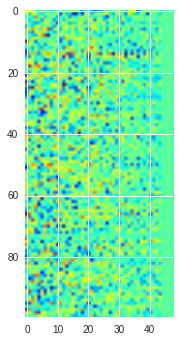

In [144]:
plt.imshow(partition_params[0][:100], cmap='jet')

In [149]:
# calculate covariances
full_c = np.ndarray(shape=(fmaps_count + 1, nv))
partition_r = np.ndarray(shape=(fmaps_count, nv))
for v in range(nv):
    full_c[0,v] = np.corrcoef(val_pred[:,v], val_voxel_data[:,v])[0,1]
    for l in range(fmaps_count):
        full_c[l+1, v] = np.corrcoef(partition_val_pred[l,:,v], val_voxel_data[:,v])[0,1]
        partition_r[l,v] = np.sign(full_c[0,v]) * np.square(full_c[0,v]) - np.sign(full_c[l+1,v]) * np.square(full_c[l+1,v])

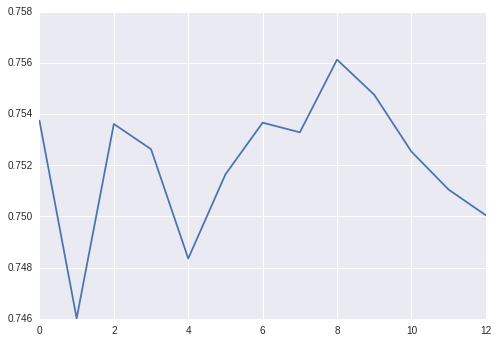

In [148]:
plt.plot(full_c[:,3566])

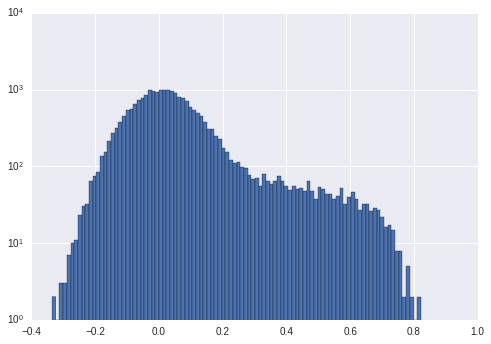

In [140]:
_=plt.hist(full_c[0], bins=100)
plt.yscale('log')

In [161]:
nROI = int(np.max(voxel_roi))+1
nL   = fmaps_count

partition_R_avg = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
partition_R_std = np.ndarray(shape=(fmaps_count, nROI), dtype=fpX)
for roi in range(nROI):
    roi_mask = np.logical_and(voxel_roi.flatten()==roi, val_cc>0.3)    
    for l in range(fmaps_count):
        partition_R_avg[l,roi] = np.mean(partition_r[l, roi_mask])
        partition_R_std[l,roi] = np.std(partition_r[l, roi_mask])
#plt.imshow(partition_R_avg, interpolation='None')

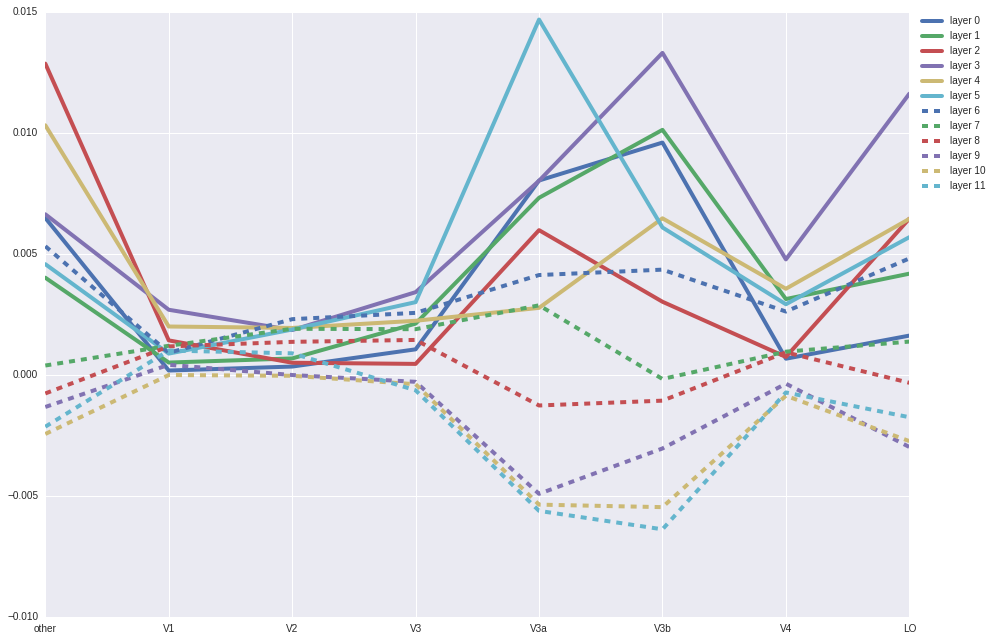

In [162]:
fig = plt.figure(figsize=(20,12))
ax = plt.subplot(111)
plt.subplots_adjust(left=.2, bottom=.2, right=.8, top=.9, wspace=.1, hspace=.1)

vrel = partition_R_avg[0][3] # + vrel - v[3]
for l, v in enumerate(partition_R_avg):
    plt.plot(v[:], label="layer %d" % l, lw=4, markersize=10, linestyle='dashed' if l>5 else 'solid')
plt.legend(bbox_to_anchor=(1.01, 1), loc=0, borderaxespad=0)
#plt.legend(plist, ['layer %d' % l for l in range(1,len(plist)+1)])
ax.set_xticklabels(roi_names)

# Residual learning

In [33]:
pred,_ = fwrf.get_prediction(mst_data, voxel_data, best_candidates, best_w_params, batches=(data_size, nx))

873 voxel batches of size 26 with residual 3
CREATING SYMBOLS

COMPILING...


874it [00:26, 34.34it/s]

0.63 seconds to compile theano functions


In [34]:
res_voxel_data = voxel_data - pred

trn_res_voxel_data = res_voxel_data[:trn_size]
val_res_voxel_data = res_voxel_data[trn_size:]

In [35]:
val_res_scores, best_res_scores, best_res_epochs, best_res_candidates, best_res_w_params = fwrf.learn_params(
        trn_mst_data, trn_res_voxel_data, voxelParams, batches=(200, 1000, 2*nx*ny), \
        holdout_size=350, lr=1e-3, l2=0.0, num_epochs=40, output_val_scores=-1, output_val_every=1, verbose=True, dry_run=False)

Grad. Desc. planned in 7 batch with batch size 200 and residual 0
22 voxel batches of size 1000 with residual 701
6 candidate batches of size 1352 with residual 0
for 184150512 voxelmodel fits.
CREATING SYMBOLS

Layer	: <lasagne.layers.input.InputLayer object at 0x7f1bd75569d0>
Name	: None
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 48, 1352)


Layer	: <src.fwrf.svFWRFLayer object at 0x7f1bd7556850>
Name	: None
Type	: <class 'src.fwrf.svFWRFLayer'>
Shape	: (None, 1000, 1352)
Params
        |-- W         : (48, 1000, 1352)


COMPILING...
0.46 seconds to compile theano functions

Voxel-Candidates model optimization...

0it [00:00, ?it/s]



  Voxel 0:1000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <loss>: 0.005664
    validation <loss>: 0.005664
    validation <loss>: 0.005665
    validation <loss>: 0.005665
    validation <loss>: 0.005666
    validation <loss>: 0.005666
    validation <loss>: 0.005667
    validation <loss>: 0.005667
    validation <loss>: 0.005668
    validation <loss>: 0.005668
    validation <loss>: 0.005668
    validation <loss>: 0.005669
    validation <loss>: 0.005669
    validation <loss>: 0.005670
    validation <loss>: 0.005670
    validation <loss>: 0.005671
    validation <loss>: 0.005671
    validation <loss>: 0.005672
    validation <loss>: 0.005672
    validation <loss>: 0.005673
    validation <loss>: 0.005673
    validation <loss>: 0.005674
    validation <loss>: 0.005674
    validation <loss>: 0.005675
    validation <loss

1it [05:54, 354.78s/it]


  Voxel 1000:2000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005625
    validation <loss>: 0.005626
    validation <loss>: 0.005627
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005629
    validation <loss>: 0.005630
    validation <loss>: 0.005630
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005634
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005636
    validation <loss>: 0.005636
    validation <loss>: 0.005637
    validation <loss>: 0.005637
    validation <loss>: 0.005638
    validation <loss>: 0.005638
    validation <loss>: 0.005638
    validation <loss>: 0.005639
    validation <loss>: 0.005639
    validation <loss>: 0.005640
    validation <lo

2it [11:49, 354.65s/it]


  Voxel 2000:3000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005636
    validation <loss>: 0.005637
    validation <loss>: 0.005638
    validation <loss>: 0.005639
    validation <loss>: 0.005640
    validation <loss>: 0.005641
    validation <loss>: 0.005642
    validation <loss>: 0.005642
    validation <loss>: 0.005643
    validation <loss>: 0.005643
    validation <loss>: 0.005644
    validation <loss>: 0.005645
    validation <loss>: 0.005645
    validation <loss>: 0.005646
    validation <loss>: 0.005646
    validation <loss>: 0.005647
    validation <loss>: 0.005647
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005649
    validation <loss>: 0.005649
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <lo

3it [17:43, 354.50s/it]


  Voxel 3000:4000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005591
    validation <loss>: 0.005591
    validation <loss>: 0.005592
    validation <loss>: 0.005592
    validation <loss>: 0.005593
    validation <loss>: 0.005594
    validation <loss>: 0.005594
    validation <loss>: 0.005595
    validation <loss>: 0.005595
    validation <loss>: 0.005595
    validation <loss>: 0.005596
    validation <loss>: 0.005596
    validation <loss>: 0.005597
    validation <loss>: 0.005597
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005598
    validation <loss>: 0.005599
    validation <loss>: 0.005599
    validation <loss>: 0.005600
    validation <loss>: 0.005600
    validation <loss>: 0.005601
    validation <loss>: 0.005601
    validation <loss>: 0.005601
    validation <loss>: 0.005602
    validation <loss>: 0.005602
    validation <loss>: 0.005603
    validation <loss>: 0.005603
    validation <loss>: 0.005604
    validation <lo

4it [23:38, 354.58s/it]


  Voxel 4000:5000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005645
    validation <loss>: 0.005647
    validation <loss>: 0.005648
    validation <loss>: 0.005649
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <loss>: 0.005653
    validation <loss>: 0.005653
    validation <loss>: 0.005654
    validation <loss>: 0.005655
    validation <loss>: 0.005655
    validation <loss>: 0.005656
    validation <loss>: 0.005656
    validation <loss>: 0.005657
    validation <loss>: 0.005657
    validation <loss>: 0.005658
    validation <loss>: 0.005658
    validation <loss>: 0.005659
    validation <loss>: 0.005659
    validation <loss>: 0.005660
    validation <loss>: 0.005660
    validation <loss>: 0.005661
    validation <loss>: 0.005661
    validation <loss>: 0.005662
    validation <loss>: 0.005662
    validation <loss>: 0.005663
    validation <lo

5it [29:33, 354.77s/it]


  Voxel 5000:6000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005550
    validation <loss>: 0.005551
    validation <loss>: 0.005552
    validation <loss>: 0.005552
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005554
    validation <loss>: 0.005554
    validation <loss>: 0.005555
    validation <loss>: 0.005555
    validation <loss>: 0.005556
    validation <loss>: 0.005556
    validation <loss>: 0.005557
    validation <loss>: 0.005557
    validation <loss>: 0.005557
    validation <loss>: 0.005558
    validation <loss>: 0.005558
    validation <loss>: 0.005559
    validation <loss>: 0.005559
    validation <loss>: 0.005559
    validation <loss>: 0.005560
    validation <loss>: 0.005560
    validation <loss>: 0.005561
    validation <loss>: 0.005561
    validation <loss>: 0.005562
    validation <loss>: 0.005562
    validation <loss>: 0.005563
    validation <loss>: 0.005563
    validation <loss>: 0.005563
    validation <lo

6it [35:31, 355.70s/it]


  Voxel 6000:7000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005636
    validation <loss>: 0.005637
    validation <loss>: 0.005638
    validation <loss>: 0.005639
    validation <loss>: 0.005640
    validation <loss>: 0.005641
    validation <loss>: 0.005641
    validation <loss>: 0.005642
    validation <loss>: 0.005643
    validation <loss>: 0.005643
    validation <loss>: 0.005644
    validation <loss>: 0.005644
    validation <loss>: 0.005645
    validation <loss>: 0.005645
    validation <loss>: 0.005646
    validation <loss>: 0.005646
    validation <loss>: 0.005647
    validation <loss>: 0.005647
    validation <loss>: 0.005648
    validation <loss>: 0.005648
    validation <loss>: 0.005649
    validation <loss>: 0.005649
    validation <loss>: 0.005650
    validation <loss>: 0.005650
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005651
    validation <loss>: 0.005652
    validation <loss>: 0.005652
    validation <lo

7it [41:25, 355.39s/it]


  Voxel 7000:8000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005539
    validation <loss>: 0.005539
    validation <loss>: 0.005539
    validation <loss>: 0.005540
    validation <loss>: 0.005540
    validation <loss>: 0.005541
    validation <loss>: 0.005541
    validation <loss>: 0.005542
    validation <loss>: 0.005542
    validation <loss>: 0.005542
    validation <loss>: 0.005543
    validation <loss>: 0.005543
    validation <loss>: 0.005544
    validation <loss>: 0.005544
    validation <loss>: 0.005544
    validation <loss>: 0.005545
    validation <loss>: 0.005545
    validation <loss>: 0.005546
    validation <loss>: 0.005546
    validation <loss>: 0.005546
    validation <loss>: 0.005547
    validation <loss>: 0.005547
    validation <loss>: 0.005548
    validation <loss>: 0.005548
    validation <loss>: 0.005549
    validation <loss>: 0.005549
    validation <loss>: 0.005549
    validation <loss>: 0.005550
    validation <loss>: 0.005550
    validation <lo

8it [47:20, 355.15s/it]


  Voxel 8000:9000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005609
    validation <loss>: 0.005610
    validation <loss>: 0.005611
    validation <loss>: 0.005612
    validation <loss>: 0.005612
    validation <loss>: 0.005613
    validation <loss>: 0.005614
    validation <loss>: 0.005614
    validation <loss>: 0.005615
    validation <loss>: 0.005615
    validation <loss>: 0.005616
    validation <loss>: 0.005616
    validation <loss>: 0.005617
    validation <loss>: 0.005617
    validation <loss>: 0.005618
    validation <loss>: 0.005618
    validation <loss>: 0.005619
    validation <loss>: 0.005619
    validation <loss>: 0.005620
    validation <loss>: 0.005620
    validation <loss>: 0.005621
    validation <loss>: 0.005621
    validation <loss>: 0.005622
    validation <loss>: 0.005622
    validation <loss>: 0.005623
    validation <loss>: 0.005623
    validation <loss>: 0.005624
    validation <loss>: 0.005624
    validation <loss>: 0.005625
    validation <lo

9it [53:15, 355.06s/it]


  Voxel 9000:10000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005550
    validation <loss>: 0.005550
    validation <loss>: 0.005551
    validation <loss>: 0.005551
    validation <loss>: 0.005552
    validation <loss>: 0.005552
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005554
    validation <loss>: 0.005554
    validation <loss>: 0.005555
    validation <loss>: 0.005555
    validation <loss>: 0.005555
    validation <loss>: 0.005556
    validation <loss>: 0.005556
    validation <loss>: 0.005557
    validation <loss>: 0.005557
    validation <loss>: 0.005557
    validation <loss>: 0.005558
    validation <loss>: 0.005558
    validation <loss>: 0.005559
    validation <loss>: 0.005559
    validation <loss>: 0.005559
    validation <loss>: 0.005560
    validation <loss>: 0.005560
    validation <loss>: 0.005561
    validation <loss>: 0.005561
    validation <loss>: 0.005561
    validation <l

10it [59:09, 354.94s/it]


  Voxel 10000:11000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005621
    validation <loss>: 0.005622
    validation <loss>: 0.005623
    validation <loss>: 0.005624
    validation <loss>: 0.005625
    validation <loss>: 0.005626
    validation <loss>: 0.005626
    validation <loss>: 0.005627
    validation <loss>: 0.005627
    validation <loss>: 0.005628
    validation <loss>: 0.005628
    validation <loss>: 0.005629
    validation <loss>: 0.005629
    validation <loss>: 0.005630
    validation <loss>: 0.005630
    validation <loss>: 0.005631
    validation <loss>: 0.005631
    validation <loss>: 0.005632
    validation <loss>: 0.005632
    validation <loss>: 0.005633
    validation <loss>: 0.005633
    validation <loss>: 0.005634
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005635
    validation <loss>: 0.005636
    validation <loss>: 0.005636
    validation <loss>: 0.005637
    validation <loss>: 0.005637
    validation <

11it [1:05:05, 355.02s/it]


  Voxel 11000:12000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005544
    validation <loss>: 0.005545
    validation <loss>: 0.005546
    validation <loss>: 0.005546
    validation <loss>: 0.005547
    validation <loss>: 0.005547
    validation <loss>: 0.005548
    validation <loss>: 0.005548
    validation <loss>: 0.005549
    validation <loss>: 0.005549
    validation <loss>: 0.005549
    validation <loss>: 0.005550
    validation <loss>: 0.005550
    validation <loss>: 0.005551
    validation <loss>: 0.005551
    validation <loss>: 0.005551
    validation <loss>: 0.005552
    validation <loss>: 0.005552
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005554
    validation <loss>: 0.005554
    validation <loss>: 0.005555
    validation <loss>: 0.005555
    validation <loss>: 0.005555
    validation <loss>: 0.005556
    validation <loss>: 0.005556
    validation <loss>: 0.005557
    validation <

12it [1:11:00, 355.06s/it]


  Voxel 12000:13000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005535
    validation <loss>: 0.005536
    validation <loss>: 0.005537
    validation <loss>: 0.005538
    validation <loss>: 0.005538
    validation <loss>: 0.005539
    validation <loss>: 0.005540
    validation <loss>: 0.005540
    validation <loss>: 0.005541
    validation <loss>: 0.005541
    validation <loss>: 0.005542
    validation <loss>: 0.005542
    validation <loss>: 0.005543
    validation <loss>: 0.005543
    validation <loss>: 0.005544
    validation <loss>: 0.005544
    validation <loss>: 0.005545
    validation <loss>: 0.005546
    validation <loss>: 0.005546
    validation <loss>: 0.005547
    validation <loss>: 0.005547
    validation <loss>: 0.005548
    validation <loss>: 0.005548
    validation <loss>: 0.005549
    validation <loss>: 0.005549
    validation <loss>: 0.005550
    validation <loss>: 0.005550
    validation <loss>: 0.005551
    validation <loss>: 0.005551
    validation <

13it [1:16:55, 354.97s/it]


  Voxel 13000:14000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005555
    validation <loss>: 0.005556
    validation <loss>: 0.005557
    validation <loss>: 0.005557
    validation <loss>: 0.005558
    validation <loss>: 0.005559
    validation <loss>: 0.005559
    validation <loss>: 0.005560
    validation <loss>: 0.005560
    validation <loss>: 0.005560
    validation <loss>: 0.005561
    validation <loss>: 0.005561
    validation <loss>: 0.005562
    validation <loss>: 0.005562
    validation <loss>: 0.005563
    validation <loss>: 0.005563
    validation <loss>: 0.005564
    validation <loss>: 0.005564
    validation <loss>: 0.005565
    validation <loss>: 0.005565
    validation <loss>: 0.005565
    validation <loss>: 0.005566
    validation <loss>: 0.005566
    validation <loss>: 0.005567
    validation <loss>: 0.005567
    validation <loss>: 0.005568
    validation <loss>: 0.005568
    validation <loss>: 0.005569
    validation <loss>: 0.005569
    validation <

14it [1:22:49, 354.82s/it]


  Voxel 14000:15000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005486
    validation <loss>: 0.005486
    validation <loss>: 0.005487
    validation <loss>: 0.005488
    validation <loss>: 0.005488
    validation <loss>: 0.005489
    validation <loss>: 0.005489
    validation <loss>: 0.005490
    validation <loss>: 0.005490
    validation <loss>: 0.005491
    validation <loss>: 0.005491
    validation <loss>: 0.005491
    validation <loss>: 0.005492
    validation <loss>: 0.005492
    validation <loss>: 0.005493
    validation <loss>: 0.005493
    validation <loss>: 0.005493
    validation <loss>: 0.005494
    validation <loss>: 0.005494
    validation <loss>: 0.005495
    validation <loss>: 0.005495
    validation <loss>: 0.005496
    validation <loss>: 0.005496
    validation <loss>: 0.005497
    validation <loss>: 0.005497
    validation <loss>: 0.005497
    validation <loss>: 0.005498
    validation <loss>: 0.005498
    validation <loss>: 0.005499
    validation <

15it [1:28:44, 354.83s/it]


  Voxel 15000:16000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005548
    validation <loss>: 0.005549
    validation <loss>: 0.005550
    validation <loss>: 0.005551
    validation <loss>: 0.005551
    validation <loss>: 0.005552
    validation <loss>: 0.005553
    validation <loss>: 0.005553
    validation <loss>: 0.005554
    validation <loss>: 0.005554
    validation <loss>: 0.005555
    validation <loss>: 0.005555
    validation <loss>: 0.005556
    validation <loss>: 0.005556
    validation <loss>: 0.005557
    validation <loss>: 0.005557
    validation <loss>: 0.005558
    validation <loss>: 0.005558
    validation <loss>: 0.005559
    validation <loss>: 0.005559
    validation <loss>: 0.005560
    validation <loss>: 0.005560
    validation <loss>: 0.005561
    validation <loss>: 0.005561
    validation <loss>: 0.005562
    validation <loss>: 0.005562
    validation <loss>: 0.005563
    validation <loss>: 0.005563
    validation <loss>: 0.005564
    validation <

16it [1:38:47, 429.32s/it]


  Voxel 16000:17000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005478
    validation <loss>: 0.005479
    validation <loss>: 0.005480
    validation <loss>: 0.005480
    validation <loss>: 0.005481
    validation <loss>: 0.005481
    validation <loss>: 0.005482
    validation <loss>: 0.005482
    validation <loss>: 0.005482
    validation <loss>: 0.005483
    validation <loss>: 0.005483
    validation <loss>: 0.005484
    validation <loss>: 0.005484
    validation <loss>: 0.005484
    validation <loss>: 0.005485
    validation <loss>: 0.005485
    validation <loss>: 0.005486
    validation <loss>: 0.005486
    validation <loss>: 0.005487
    validation <loss>: 0.005487
    validation <loss>: 0.005487
    validation <loss>: 0.005488
    validation <loss>: 0.005488
    validation <loss>: 0.005489
    validation <loss>: 0.005489
    validation <loss>: 0.005490
    validation <loss>: 0.005490
    validation <loss>: 0.005490
    validation <loss>: 0.005491
    validation <

17it [1:49:08, 486.76s/it]


  Voxel 17000:18000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005479
    validation <loss>: 0.005480
    validation <loss>: 0.005480
    validation <loss>: 0.005481
    validation <loss>: 0.005482
    validation <loss>: 0.005482
    validation <loss>: 0.005483
    validation <loss>: 0.005483
    validation <loss>: 0.005484
    validation <loss>: 0.005484
    validation <loss>: 0.005485
    validation <loss>: 0.005485
    validation <loss>: 0.005486
    validation <loss>: 0.005486
    validation <loss>: 0.005487
    validation <loss>: 0.005487
    validation <loss>: 0.005488
    validation <loss>: 0.005488
    validation <loss>: 0.005489
    validation <loss>: 0.005489
    validation <loss>: 0.005490
    validation <loss>: 0.005490
    validation <loss>: 0.005491
    validation <loss>: 0.005491
    validation <loss>: 0.005492
    validation <loss>: 0.005492
    validation <loss>: 0.005493
    validation <loss>: 0.005493
    validation <loss>: 0.005494
    validation <

18it [1:59:29, 527.12s/it]


  Voxel 18000:19000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005494
    validation <loss>: 0.005495
    validation <loss>: 0.005495
    validation <loss>: 0.005496
    validation <loss>: 0.005497
    validation <loss>: 0.005497
    validation <loss>: 0.005498
    validation <loss>: 0.005498
    validation <loss>: 0.005499
    validation <loss>: 0.005499
    validation <loss>: 0.005499
    validation <loss>: 0.005500
    validation <loss>: 0.005500
    validation <loss>: 0.005501
    validation <loss>: 0.005501
    validation <loss>: 0.005501
    validation <loss>: 0.005502
    validation <loss>: 0.005502
    validation <loss>: 0.005503
    validation <loss>: 0.005503
    validation <loss>: 0.005503
    validation <loss>: 0.005504
    validation <loss>: 0.005504
    validation <loss>: 0.005505
    validation <loss>: 0.005505
    validation <loss>: 0.005506
    validation <loss>: 0.005506
    validation <loss>: 0.005506
    validation <loss>: 0.005507
    validation <

19it [2:09:51, 555.45s/it]


  Voxel 19000:20000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005481
    validation <loss>: 0.005482
    validation <loss>: 0.005482
    validation <loss>: 0.005483
    validation <loss>: 0.005483
    validation <loss>: 0.005484
    validation <loss>: 0.005484
    validation <loss>: 0.005485
    validation <loss>: 0.005485
    validation <loss>: 0.005485
    validation <loss>: 0.005486
    validation <loss>: 0.005486
    validation <loss>: 0.005486
    validation <loss>: 0.005487
    validation <loss>: 0.005487
    validation <loss>: 0.005488
    validation <loss>: 0.005488
    validation <loss>: 0.005488
    validation <loss>: 0.005489
    validation <loss>: 0.005489
    validation <loss>: 0.005490
    validation <loss>: 0.005490
    validation <loss>: 0.005491
    validation <loss>: 0.005491
    validation <loss>: 0.005491
    validation <loss>: 0.005492
    validation <loss>: 0.005492
    validation <loss>: 0.005493
    validation <loss>: 0.005493
    validation <

20it [2:20:12, 575.28s/it]


  Voxel 20000:21000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005451
    validation <loss>: 0.005452
    validation <loss>: 0.005452
    validation <loss>: 0.005453
    validation <loss>: 0.005454
    validation <loss>: 0.005454
    validation <loss>: 0.005455
    validation <loss>: 0.005455
    validation <loss>: 0.005456
    validation <loss>: 0.005456
    validation <loss>: 0.005457
    validation <loss>: 0.005457
    validation <loss>: 0.005457
    validation <loss>: 0.005458
    validation <loss>: 0.005458
    validation <loss>: 0.005459
    validation <loss>: 0.005459
    validation <loss>: 0.005460
    validation <loss>: 0.005460
    validation <loss>: 0.005461
    validation <loss>: 0.005461
    validation <loss>: 0.005462
    validation <loss>: 0.005462
    validation <loss>: 0.005463
    validation <loss>: 0.005463
    validation <loss>: 0.005464
    validation <loss>: 0.005464
    validation <loss>: 0.005464
    validation <loss>: 0.005465
    validation <

21it [2:30:34, 589.22s/it]


  Voxel 21000:22000 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.005416
    validation <loss>: 0.005416
    validation <loss>: 0.005417
    validation <loss>: 0.005418
    validation <loss>: 0.005418
    validation <loss>: 0.005419
    validation <loss>: 0.005419
    validation <loss>: 0.005420
    validation <loss>: 0.005420
    validation <loss>: 0.005421
    validation <loss>: 0.005421
    validation <loss>: 0.005422
    validation <loss>: 0.005422
    validation <loss>: 0.005423
    validation <loss>: 0.005423
    validation <loss>: 0.005424
    validation <loss>: 0.005424
    validation <loss>: 0.005425
    validation <loss>: 0.005425
    validation <loss>: 0.005426
    validation <loss>: 0.005426
    validation <loss>: 0.005427
    validation <loss>: 0.005427
    validation <loss>: 0.005428
    validation <loss>: 0.005428
    validation <loss>: 0.005429
    validation <loss>: 0.005429
    validation <loss>: 0.005430
    validation <loss>: 0.005430
    validation <

22it [2:40:50, 597.20s/it]


  Voxel 22000:22701 of 22701, Candidate 0:1352 of 8112
    validation <loss>: 0.003809
    validation <loss>: 0.003809
    validation <loss>: 0.003810
    validation <loss>: 0.003810
    validation <loss>: 0.003810
    validation <loss>: 0.003811
    validation <loss>: 0.003811
    validation <loss>: 0.003811
    validation <loss>: 0.003812
    validation <loss>: 0.003812
    validation <loss>: 0.003812
    validation <loss>: 0.003813
    validation <loss>: 0.003813
    validation <loss>: 0.003813
    validation <loss>: 0.003814
    validation <loss>: 0.003814
    validation <loss>: 0.003814
    validation <loss>: 0.003815
    validation <loss>: 0.003815
    validation <loss>: 0.003815
    validation <loss>: 0.003816
    validation <loss>: 0.003816
    validation <loss>: 0.003816
    validation <loss>: 0.003817
    validation <loss>: 0.003817
    validation <loss>: 0.003817
    validation <loss>: 0.003818
    validation <loss>: 0.003818
    validation <loss>: 0.003818
    validation <

23it [2:51:14, 605.23s/it]


---------------------------------------------------------------------
40 Epoch for 184150512 voxelmodels took 10274.168s @ 17923.642 voxelmodels/s


In [36]:
best_res_rf_params, best_res_avg, best_res_std = fwrf.real_space_model(best_res_candidates, sharedModel_specs, mst_avg=mst_avg, mst_std=mst_std)

In [37]:
val_res_pred, val_res_cc = fwrf.get_prediction(val_mst_data, val_res_voxel_data, best_res_candidates, best_res_w_params, batches=(500, 2*ny*nx))

16 voxel batches of size 1352 with residual 1069
CREATING SYMBOLS

COMPILING...


17it [00:01,  8.80it/s]

0.48 seconds to compile theano functions


max cc = 0.568488
sum(cc>0.2) = 790


(-0.4, 0.9)

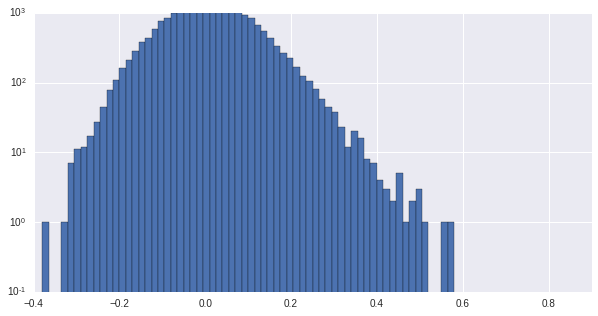

In [65]:
print "max cc = %f" % np.max(val_res_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, val_res_cc))
plt.figure(figsize=(10,5))
_=plt.hist(val_res_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

In [75]:
ex_file_name = output_dir + "fwrf_%s_%s_%s_residual.pkl" % (model_name, subject, timestamp)
ex_file = open(ex_file_name, 'wb')
ex_values = {'project': 'fwrf',
             'dataset': 'vim-1',
             'subject': subject,
             'model_name': model_name,
             'grid': [sharedModel_specs[1][0](*sharedModel_specs[0][0]), 
                      sharedModel_specs[1][1](*sharedModel_specs[0][1]),
                      sharedModel_specs[1][2](*sharedModel_specs[0][2])],
             'gabor_params': gabor_params,
             'voxel_idx': voxel_idx,
             'voxel_roi': voxel_roi,             
             'fmaps_res_count': fmaps_res_count,
             'fmaps_count': fmaps_count,
             'fmaps_sizes': fmaps_sizes, 
             'scores': best_res_scores,
             'rf_params': best_res_rf_params,
             'w_params': best_res_w_params,
             'normavg': best_res_avg,
             'normstd': best_res_std, 
             'val_pred': val_res_pred,
             'val_cc': val_res_cc}
pickle.dump(ex_values, ex_file)
ex_file.close()
print ex_file_name

/home/styvesg/Documents/PostDoc/GitRepo/fwrf/output/fwrf_gabor_S1_Sep-19-2017_1214_residual.pkl


In [67]:
pred = val_pred + val_res_pred

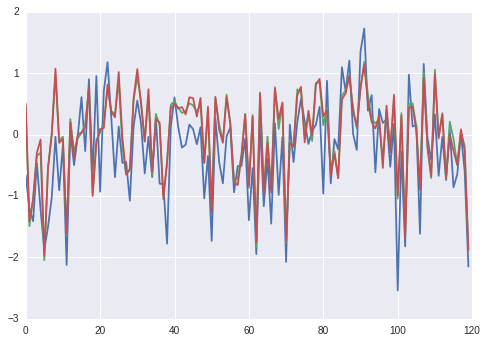

In [74]:
plt.plot(val_voxel_data[:,vidx])
plt.plot(val_pred[:,vidx])
plt.plot(pred[:,vidx], )

In [68]:
pred_cc = np.zeros(shape=[nv,])
for v in range(nv):
    pred_cc[v] = np.corrcoef(pred[:,v], val_voxel_data[:,v])[0,1]

max cc = 0.819759
sum(cc>0.2) = 2876


(-0.4, 0.9)

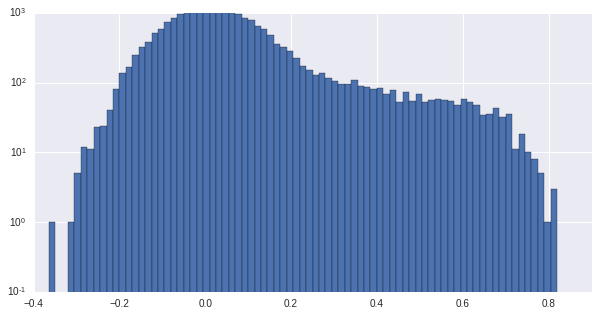

In [69]:
print "max cc = %f" % np.max(pred_cc)
print "sum(cc>0.2) = %d" % np.sum(map(lambda x: x > 0.2, pred_cc))
plt.figure(figsize=(10,5))
_=plt.hist(pred_cc[:], bins=100, range=(-.5, 1.))
plt.yscale('log')
plt.ylim([10**-1, 10**3])
plt.xlim([-.4, 0.9])

In [70]:
print val_cc.shape

(22701,)


(-0.25, 0.9)

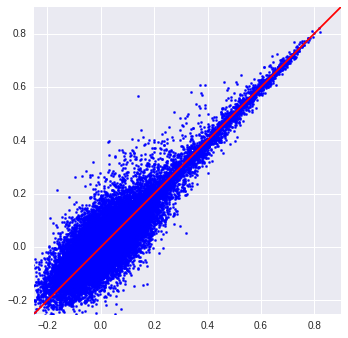

In [71]:
plt.scatter(x=val_cc, y=pred_cc, marker='.', color='b')
plt.plot([-.5,1], [-.5,1], color='r', linestyle='-')
plt.axes().set_aspect('equal')
plt.xlim([-.25, .9])
plt.ylim([-.25, .9])

[-9.61538506 -1.92307687  0.5       ]


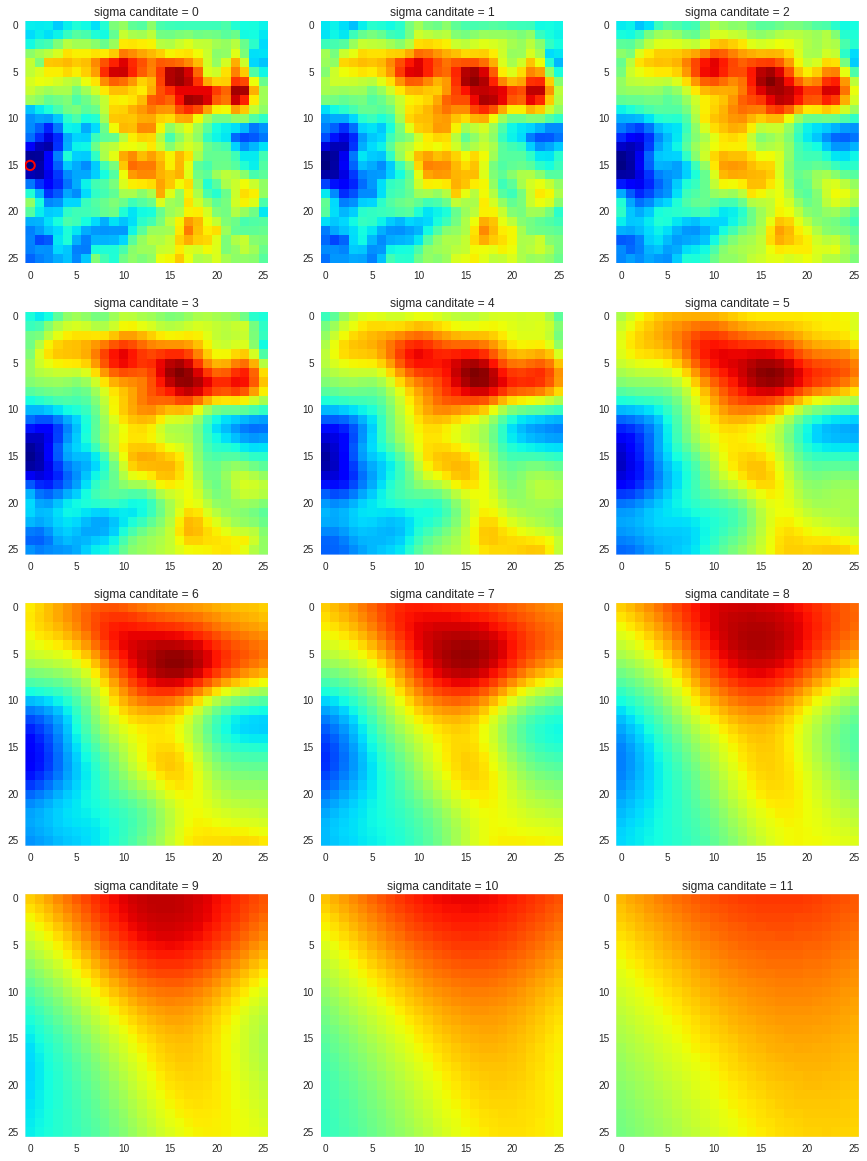

In [72]:
print best_res_rf_params[vidx,:]
fig1 = display_candidate_loss(val_res_scores[-1,vidx,:], nx, ny, ns)